# Loading basic dependencies and class


In [2]:
import LineModels as LM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits 
import scipy
from scipy import signal
import scipy.interpolate as interpolate

%load_ext autoreload
%autoreload 2


# Reading and loading the spectrum

We will use the **Iz18W** data already in the folder for this example. Note that currently, we must load the continuum-divide rest-frame spectrum, i.e., the spectrum where the stellar continuum has been removed, and redshift corrected. For *CLASSY* spectra, we do have the stellar continuum fit of each galaxy. If you need to apply this to other spectra where you do not have it, just let me know.

In [5]:
gal   = fits.open('hlsp_classy_hst_cos_j0934+5514_multi_v2_coadded.fits')

## We'll use the high-resolution, binned spectrum
HRB      = gal[10].data # Rest-frame, galactic extinction-corrected, co-added, binned high-resolution spectrum 
FHWM_obs = 105 # From Table 3 in Berg+22
wHB, fHB, eHB = HRB['WAVE'], HRB['FLUX DENSITY'], HRB['ERROR']
redshift = 0.0025

## Normalizing using stellar continuum fit

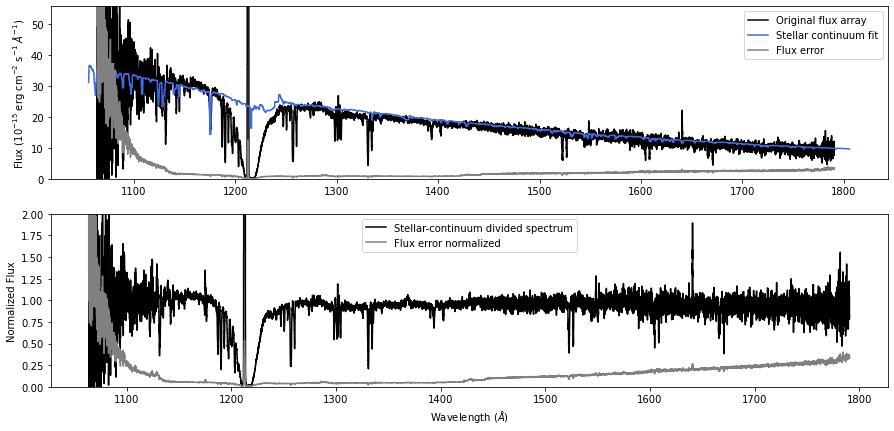

In [6]:
## Loading the stellar continuum fit
gal            = fits.open('J0934+5514_SB99fit.fits')
stell_fit      = gal[1].data['fit']
#Using a medium filter to remove features from SB99 models which are not physical
stell_fit      = scipy.signal.medfilt(stell_fit, 25) 
#Originally, the stellar continuum fit is  fit on normalized spectra, so we put it back with right units
stell_corr_fit = gal[1].data['norm'][0]*stell_fit

## Assigning the right variables 
wave = wHB # Wavelength array
flux = fHB/stell_corr_fit # Continuum divided flux array
err  = eHB/stell_corr_fit # Same operation must apply to the error array

## Plot both
fig, (ax1, ax2) = plt.subplots(2,1, figsize = (15,7))
ax1.plot(wave, fHB, c='k', drawstyle='steps-mid', label = 'Original flux array')
ax1.plot(wave, stell_corr_fit, c='royalblue', drawstyle='steps-mid', label = 'Stellar continuum fit')
ax1.plot(wave, eHB, c='gray', drawstyle='steps-mid', label = 'Flux error')
ax1.set_ylim(0,np.nanmedian(fHB)+0.4*np.nanstd(fHB))
# ax1.set_xlabel(r'Wavelength ($\AA$)')
ax1.set_ylabel(r'Flux (10$^{-15}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$)')

ax1.legend()

ax2.plot(wave, flux, c='k', drawstyle='steps-mid', label = 'Stellar-continuum divided spectrum')
ax2.plot(wave, err, c='gray', drawstyle='steps-mid', label = 'Flux error normalized')
ax2.set_ylim(0,2)
ax2.set_xlabel(r'Wavelength ($\AA$)')
ax2.set_ylabel(r'Normalized Flux')
ax2.legend()


## Removing continuum with spline fit

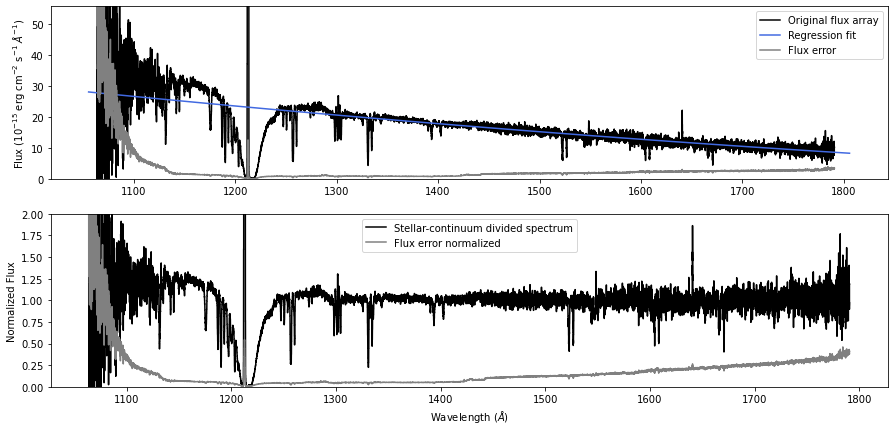

In [7]:
#Heavy median filter to remove fluctuations
flux_to_fit = scipy.signal.medfilt(fHB, 91) 

#Masking nan values
mask = np.isnan(wHB) | np.isnan(flux_to_fit) | (wHB < 1230)
z = np.polyfit(wHB[~mask], flux_to_fit[~mask],2)
reg_fit = np.poly1d(z)

## Assigning the right variables 
wave = wHB # Wavelength array
flux = fHB/reg_fit(wHB) # Continuum divided flux array
err  = eHB/reg_fit(wHB) # Same operation must apply to the error array

## Plot both
fig, (ax1, ax2) = plt.subplots(2,1, figsize = (15,7))
ax1.plot(wave, fHB, c='k', drawstyle='steps-mid', label = 'Original flux array')
ax1.plot(wave, reg_fit(wHB), c='royalblue', drawstyle='steps-mid', label = 'Regression fit')
ax1.plot(wave, eHB, c='gray', drawstyle='steps-mid', label = 'Flux error')
ax1.set_ylim(0,np.nanmedian(fHB)+0.4*np.nanstd(fHB))
# ax1.set_xlabel(r'Wavelength ($\AA$)')
ax1.set_ylabel(r'Flux (10$^{-15}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$)')

ax1.legend()

ax2.plot(wave, flux, c='k', drawstyle='steps-mid', label = 'Stellar-continuum divided spectrum')
ax2.plot(wave, err, c='gray', drawstyle='steps-mid', label = 'Flux error normalized')
ax2.set_ylim(0,2)
ax2.set_xlabel(r'Wavelength ($\AA$)')
ax2.set_ylabel(r'Normalized Flux')
ax2.legend()




# Let's do some fitting

## Initializing the class

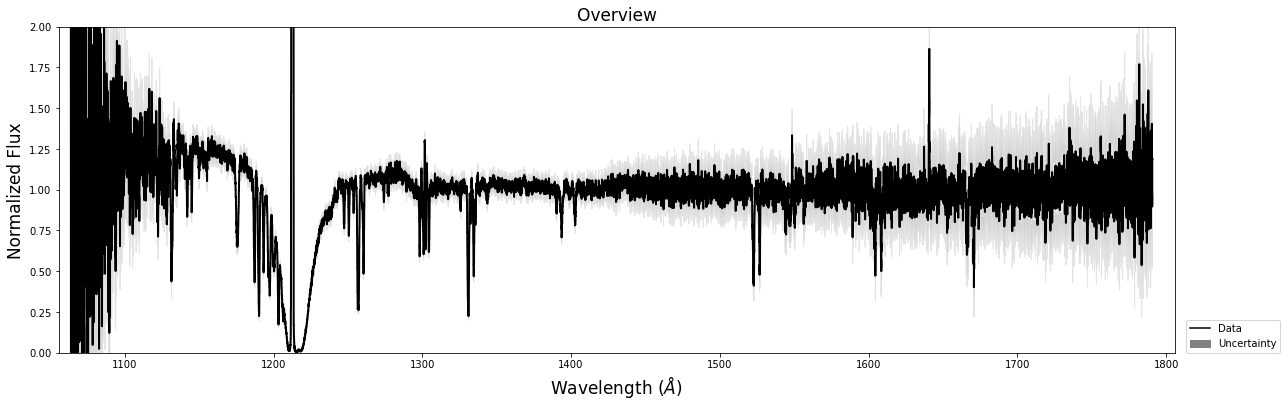

In [8]:
#The class requires the wavelength array (rest-frame), the continuum-divided flux,  the galaxy redshift, and
# the sigma_res (FHWM/2.355)
%autoreload 2

LModel = LM.FitController(wave, flux, err, redshift = redshift, vdisp = FHWM_obs/2.355)
fig = LModel.plot_spectra()


## Choose absorption lines to fit

### Display some lines

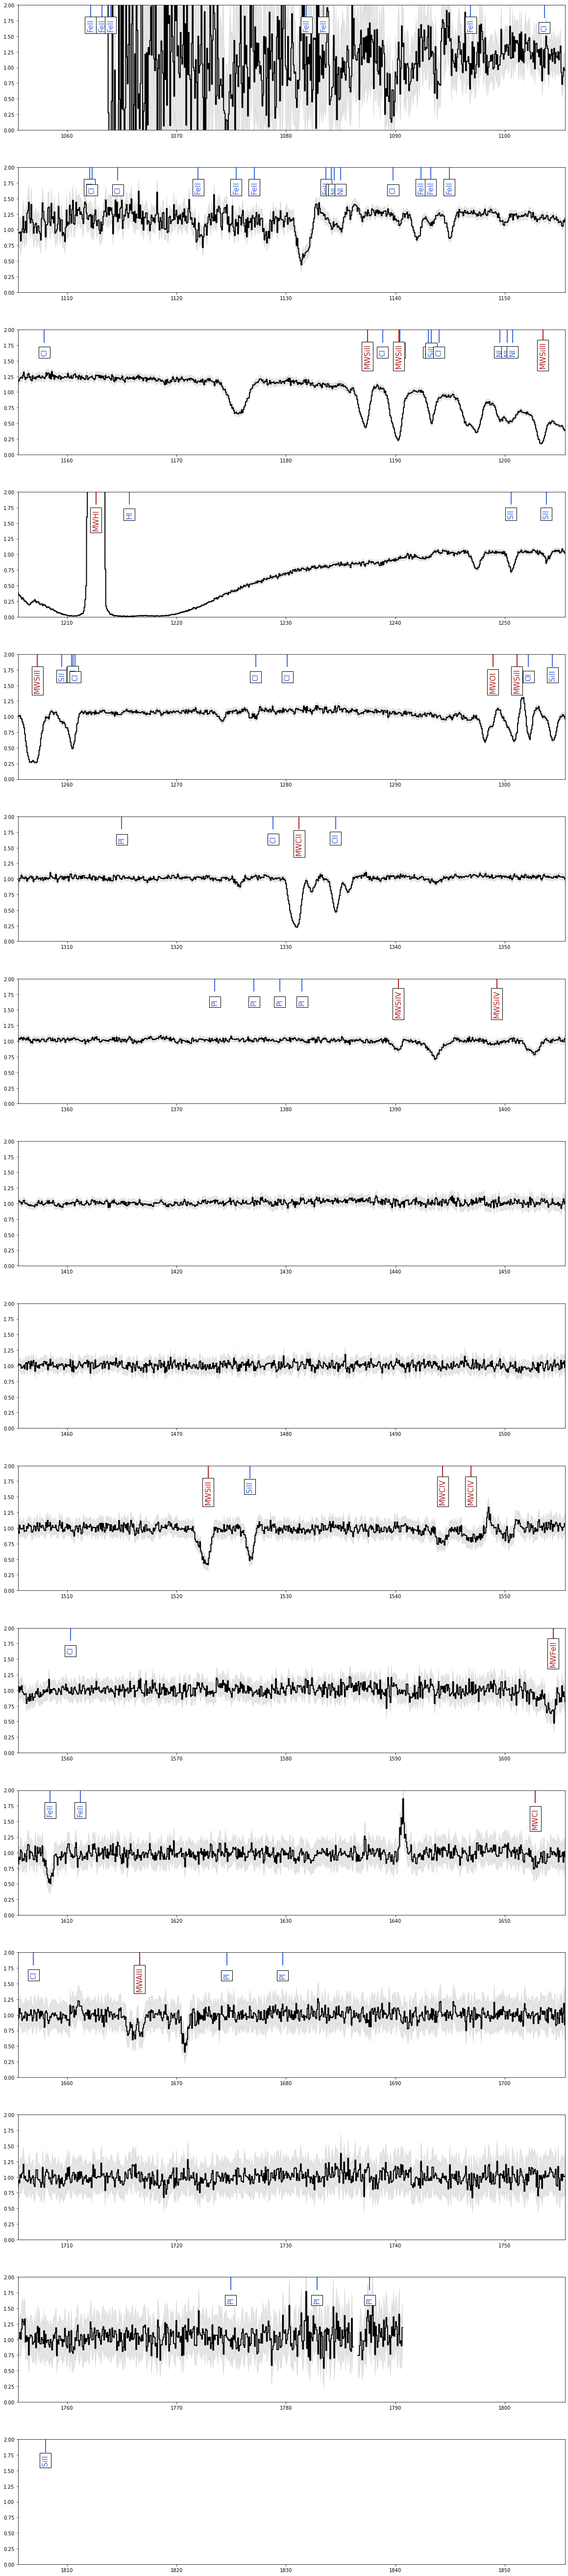

In [12]:
fig = LModel.plot_lines(['HI', 'OI', 'NI', 'CII', 'SiII', 'CI', 'SII', 'FeII', 'PI'])

#### Print list of lines

In [89]:
%autoreload 2
LModel.print_lines()

------------ List of lines which can be included --------------
	 -- H I ;
  Name      Wave        f           A
 HI917  917.1806 0.000723   1910000.0
 HI918  918.1294 0.000921   2430000.0
 HI919  919.3514 0.001200   3160000.0
 HI920  920.9631 0.001610   4210000.0
 HI923  923.1504 0.002220   5780000.0
 HI926  926.2257 0.003180   8240000.0
 HI930  930.7483 0.004820  12400000.0
 HI937  937.8035 0.007800  24500000.0
 HI949  949.7431 0.013900  42000000.0
 HI972  972.5368 0.029000  81300000.0
HI1025 1025.7223 0.079100 190000000.0
HI1216 1215.6701 0.416000 627000000.0
-----------
	 -- O I ;
   Name      Wave        f           A
  OI929  929.5170 0.001930  10600000.0
  OI930  930.2570 0.000537   6900000.0
  OI936  936.6290 0.003050  16600000.0
  OI948  948.6855 0.005300  28100000.0
  OI950  950.8846 0.001570  38800000.0
  OI971  971.7380 0.012400  66000000.0
  OI972  972.1428 0.000317  15000000.0
  OI976  976.4481 0.003300  80100000.0
  OI988  988.7730 0.043200 239000000.0
 OI*990  990.2043 

### Choose lines to fit

In [68]:
LModel.include_lines(['HI1216','SiII1190', 'SiII1193','SiII1260', 'NI1199', 'NI1200.2', 'NI1200.7'])

------------ List of lines included in the fit --------------
 H with 1 line(s) included:
	 -- H I ;
  Name      Wave     f           A
HI1216 1215.6701 0.416 627000000.0
-----------
 Si with 3 line(s) included:
	 -- Si II ;
    Name      Wave     f            A
SiII1190 1190.4158 0.293 4080000000.0
SiII1193 1193.2897 0.584 4070000000.0
SiII1260 1260.4221 1.180 2950000000.0
-----------
 N with 3 line(s) included:
	 -- N I ;
    Name      Wave      f           A
  NI1199 1199.5496 0.1330 410000000.0
NI1200.2 1200.2233 0.0885 410000000.0
NI1200.7 1200.7098 0.0442 409000000.0
-----------
Initializing the parameters for each ion
HI initial parameters with the following values:
	 Velocity (vHI) - value 0 - Bounds [-500, 200]
	 Doppler parameter (bHI) - value 20 - Bounds [0, 300]
	 log10 Column density (lognHI) - value 18 - Bounds [12, 22]
	 Covering fraction: (fcovHI) - value 1 - Bounds [0, 1]

SiII initial parameters with the following values:
	 Velocity (vSiII) - value 0 - Bounds [-500, 2

#### Modifications of parameters

In [69]:
# Changing central value
LModel.update_parameter('lognSiII', maxV= 16)
LModel.update_parameter('lognNI', maxV= 16)

# Changing bounds
LModel.update_parameter('bSiII', maxV= 150, minV= 1)

# Fixing a parameter with respect to another
LModel.update_parameter('vHI', expr = 'vSiII') #force the fit to have v(Si II) = v(N I)

# Fixing a parameters so it's not fitted
# LModel.update_parameter('lognNI', vary= False)


Parameters updated for lognSiII: value 14 - Bounds [11, 16]
Parameters updated for lognNI: value 14 - Bounds [11, 16]
Parameters updated for bSiII: value 20 - Bounds [1, 150]
Parameters updated for vHI: new expression vSiII


## Defining masks

### Basic method 1

The user is providing his own masks (good job user!)
Showing the spectrum with masks


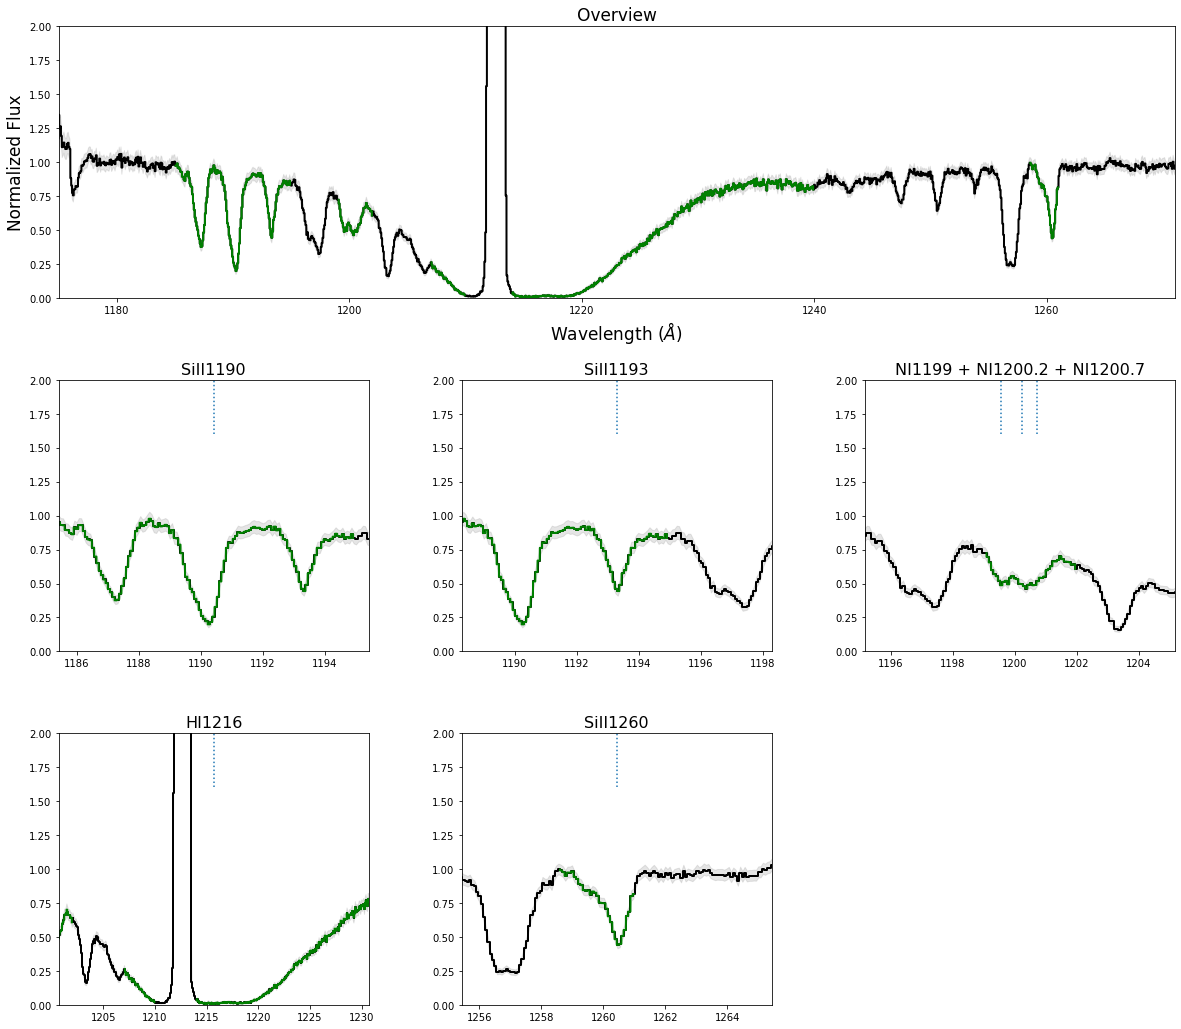

In [58]:
%matplotlib inline
LModel.define_masks([[1185,1195], [1199, 1202], [1207,1210], [1214, 1240],[1258.5,1261]])


### Interactive

#### Typing

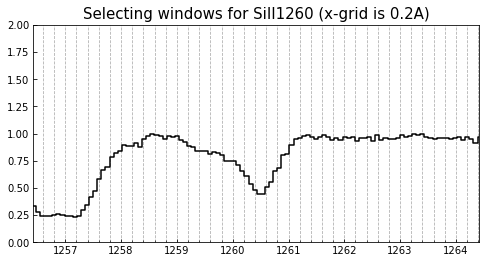

KeyboardInterrupt: Interrupted by user

In [583]:
LModel.define_masks(interactive = 1)


#### Clicking

In [ ]:
import matplotlib.pyplot as plt


class InteractivePlot:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.ranges = []
        self.fig, self.ax = plt.subplots(figsize = (20,5))
        self.ax.plot(self.x, self.y, c = 'k')
        self.ax.set_title('Select ranges by clicking and dragging, press Enter when finished')
        self.ax.set_xlabel('x')
        self.ax.set_ylabel('y')
        self.ax.set_xlim([min(self.x), max(self.x)])
        self.ax.set_ylim(0,2)
        self.ax.set_autoscale_on(False)
        self.ax.callbacks.connect('xlim_changed', self.update)
        self.fig.canvas.mpl_connect('button_press_event', self.on_press)
        self.fig.canvas.mpl_connect('button_release_event', self.on_release)
        self.fig.canvas.mpl_connect('motion_notify_event', self.on_motion)
        self.fig.canvas.mpl_connect('key_press_event', self.on_key_press)

    def on_press(self, event):
        if event.button == 1:
            self.start = event.xdata

    def on_release(self, event):
        if event.button == 1:
            self.end = event.xdata
            if self.start != self.end:
                if self.start > self.end:
                    self.start, self.end = self.end, self.start
                self.ranges.append((self.start, self.end))
                self.draw()

    def on_motion(self, event):
        if event.button == 1:
            self.end = event.xdata
            self.draw()

    def on_key_press(self, event):
        if event.key == 'enter':
            plt.close()

    def update(self, event):
        self.ax.set_xlim([min(self.x), max(self.x)])
        self.ax.set_ylim([min(self.y), max(self.y)])
        self.draw()

    def draw(self):
        self.ax.lines = []
        self.ax.plot(self.x, self.y, c = 'k')
        for start, end in self.ranges:
            self.ax.axvspan(start, end, color='gray', alpha=0.5)
        self.fig.canvas.draw()


In [ ]:
%matplotlib notebook

plot = InteractivePlot(wave,flux)
plt.show()

#VERY badly coded...

ranges = plot.ranges
print(ranges)



In [ ]:
%matplotlib inline
LModel.define_masks(ranges)


## Adding MW lines

### Automatic 

In [64]:
### See column MW in linelist.csv to add more lines
%autoreload 2
LModel.include_MW_lines()

Automatically checking MW lines falling in masks (Only a subset of strong lines are considered)

SiII1190's wavelength (1187.45 A in host galaxy rest-frame) is in your masks
SiII1193's wavelength (1190.31 A in host galaxy rest-frame) is in your masks
------------ List of MW lines included in the fit --------------
 Si with 2 line(s) included:
	 -- Si II ;
    Name     MW_Wave
SiII1190 1187.447182
SiII1193 1190.313915
-----------
Initializing the parameters for each MW ion
SiII initial parameters with the following values:
	 Velocity (vMWSiII) - value 0 - Bounds [-40, 20]
	 Doppler parameter (bMWSiII) - value 30 , fixed
	 log10 Column density (lognMWSiII) - value 14 - Bounds [13, 16]
	 Covering fraction: (fcovMWSiII) fixed to 1



### Manual

In [74]:
LModel.include_MW_lines(['SiII1190', 'SiII1193', 'HI1216'])
LModel.update_parameter('vMWSiII', expr = 'vMWHI') #force the fit to have v(Si II) = v(H I)


------------ List of MW lines included in the fit --------------
 H with 1 line(s) included:
	 -- H I ;
  Name     MW_Wave
HI1216 1212.638504
-----------
 Si with 2 line(s) included:
	 -- Si II ;
    Name     MW_Wave
SiII1190 1187.447182
SiII1193 1190.313915
-----------
Initializing the parameters for each MW ion
SiII initial parameters with the following values:
	 Velocity (vMWSiII) - value 0 - Bounds [-40, 20]
	 Doppler parameter (bMWSiII) - value 30 , fixed
	 log10 Column density (lognMWSiII) - value 14 - Bounds [13, 16]
	 Covering fraction: (fcovMWSiII) fixed to 1

HI initial parameters with the following values:
	 Velocity (vMWHI) - value 0 - Bounds [-40, 20]
	 Doppler parameter (bMWHI) - value 30 , fixed
	 log10 Column density (lognMWHI) - value 19 - Bounds [18, 23]
	 Covering fraction: (fcovMWHI) fixed to 1

Parameters updated for vMWSiII: new expression vMWHI


## Do the fitting

Parameters updated for vHI: new expression vSiII
Parameters updated for vNI: new expression vSiII
Parameters updated for fcovNI: new expression fcovSiII
If you do not use a global optimization solver, it is advised to perform the fit several times and use median & IQ
Default absorption fitting approach with leastsq solver, 1 iteration only
Launching fit

Fit done! Time elapsed 0.75 s

Ion parameters from fit
Line name: HI
Velocity (v): 1.7 +- 3.0 km/s
Doppler parameter (b): 1.2 +- 21163.8 km/s
Column density (log N): 21.23 +- 0.01 cm^-2
Covering fraction (f_cov): 0.973 +- 0.00

Line name: SiII
Velocity (v): 1.7 +- 3.0 km/s
Doppler parameter (b): 54.8 +- 6.1 km/s
Column density (log N): 14.59 +- 0.23 cm^-2
Covering fraction (f_cov): 0.492 +- 0.02

Line name: NI
Velocity (v): 1.7 +- 3.0 km/s
Doppler parameter (b): 33.2 +- 1.8 km/s
Column density (log N): 14.89 +- 0.12 cm^-2
Covering fraction (f_cov): 0.492 +- 0.02

MW Ion parameters from fit
Line name: SiII
Velocity (v): -40.0 +- 0.5 km/

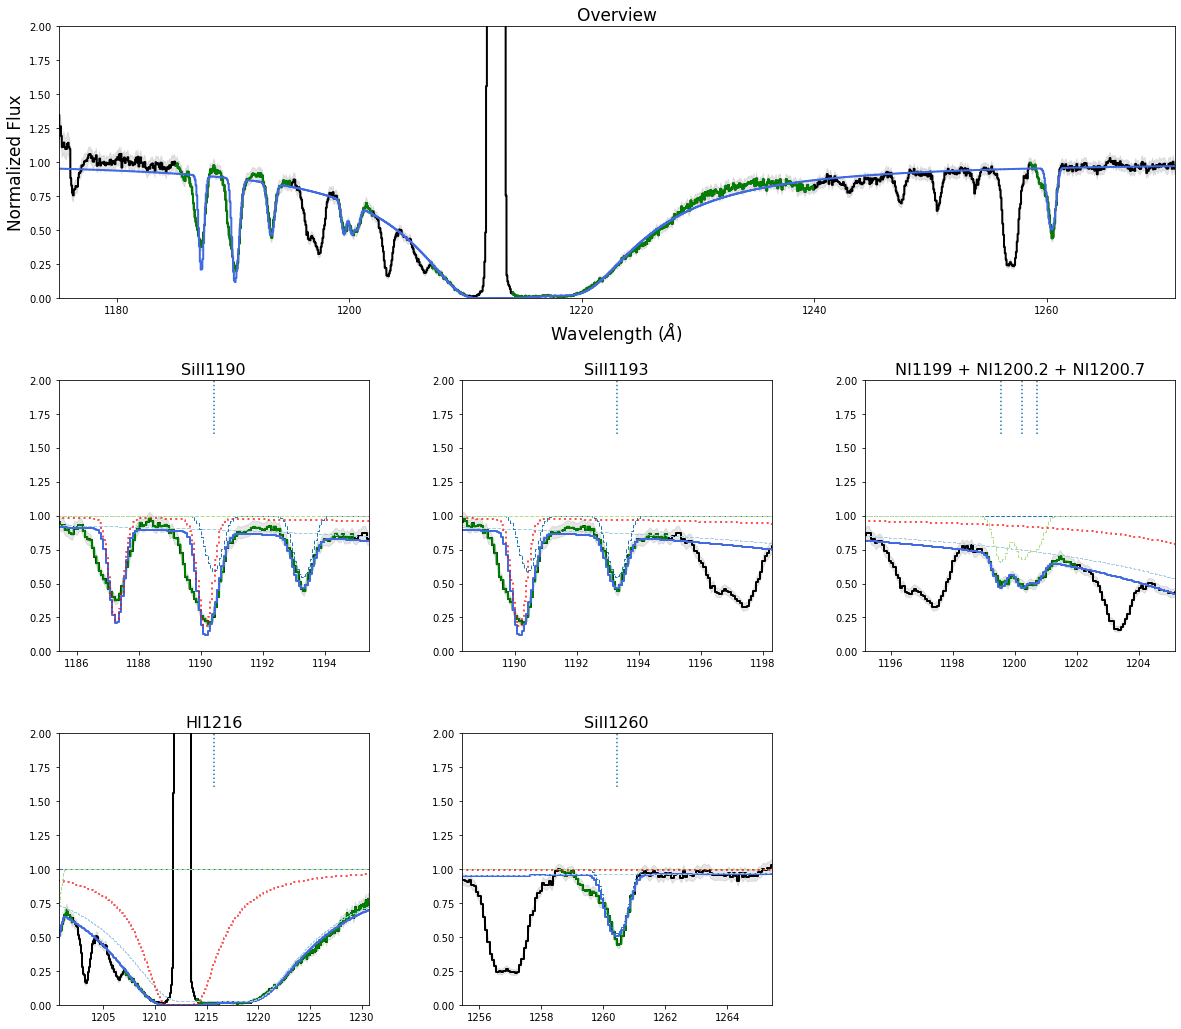

In [76]:
LModel.update_parameter('vHI', expr = 'vSiII') #force the fit to have v(Si II) = v(H I)
LModel.update_parameter('vNI', expr = 'vSiII') #force the fit to have v(Si II) = v(N I)
LModel.update_parameter('fcovNI', expr = 'fcovSiII') #force the fit to have v(Si II) = v(N I)


fitted = LModel.fit_model(method = 'leastsq') # For quick but maybe bad fit
# fitted = LModel.fit_model(method = 'ampgo') # Long but best solution (minimal chi2, global optimization)

### Extract parameters and ion spectra 

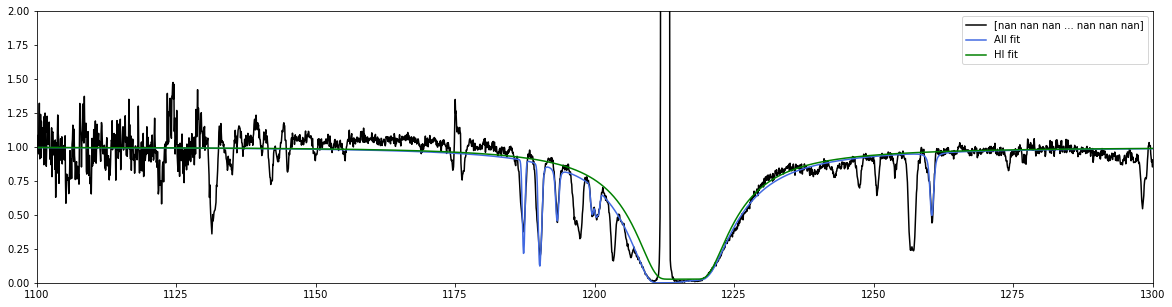

Velocity of HI 5.099523939377718


In [45]:
spectra = LModel.get_spectra()
# spectra['all'] : All spectra
# spectra['HI'] : HI line spectra
# spectra['MWHI'] : MW HI line spectra

plt.figure(figsize = (20,5))
plt.plot(spectra['wave'], spectra['flux'], c= 'k', label = flux)
plt.plot(spectra['wave'], spectra['all'], c= 'royalblue', label = 'All fit')
plt.plot(spectra['wave'], spectra['HI'], c= 'green', label = 'HI fit')
plt.legend()
plt.xlim(1100,1300)
plt.ylim(0,2)
plt.show()
fitted_params = LModel.get_parameters()
print('Velocity of HI', fitted_params['HI']['v'])

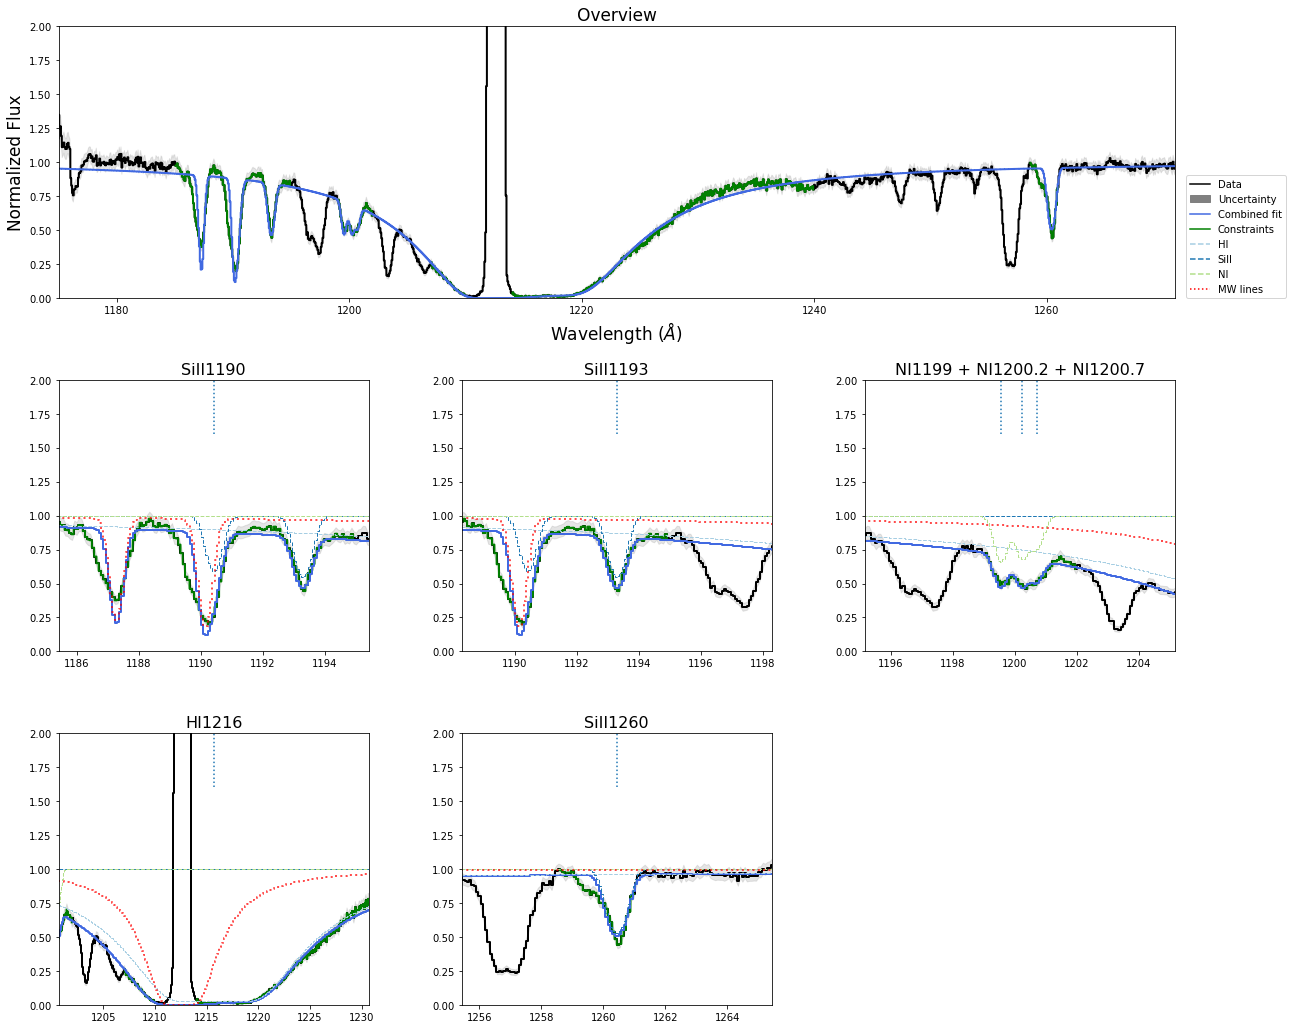

In [86]:
fig = LModel.plot_spectra(masks=True, fit = True, fit_ion=True, fit_MW_ion=True)